In [1]:
import re
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx
from bids.layout import BIDSLayout
import matplotlib.pyplot as plt
from multiprocessing.pool import Pool
from statsmodels.stats.multitest import multipletests

In [2]:
N_THREADS = 32

In [3]:
lss_layout = BIDSLayout('../lss/nibetaseries', validate=False, config=['bids', 'derivatives'])
lsa_layout = BIDSLayout('../lsa/nibetaseries', validate=False, config=['bids', 'derivatives'])

## Test results with LSS

In [4]:
test_layout = lss_layout

In [5]:
fauxbold_objs = test_layout.get(
    suffix="correlation", extension="tsv", task="fauxbold", desc="switch")
taskswitch_objs = test_layout.get(
    suffix="correlation", extension="tsv", task="taskswitch", desc="switch")

# this participant cannot fit the lss model
taskswitch_filt_objs = [ob for ob in taskswitch_objs if ob.entities['subject'] != 'GE120056']

### Play with taskswitch to get summary

In [6]:
taskswitch_objs[0].entities['subject']

'GE120001'

In [7]:
test_df = pd.read_csv(fauxbold_objs[1].path, index_col=0, sep="\t")
test_df.head()

,LH-VisCent-ExStr_1,LH-VisCent-ExStr_2,LH-VisCent-ExStr_3,LH-VisCent-ExStr_4,LH-VisCent-ExStr_5,LH-VisCent-ExStr_6,LH-VisCent-ExStr_7,LH-VisCent-ExStr_8,LH-VisCent-ExStr_9,LH-VisCent-ExStr_10,...,RH-TempPar-1,RH-TempPar-2,RH-TempPar-3,RH-TempPar-4,RH-TempPar-5,RH-TempPar-6,RH-TempPar-7,RH-TempPar-8,RH-TempPar-9,RH-TempPar-10
LH-VisCent-ExStr_1,NaN,0.536898,0.959091,0.788185,0.379014,-0.078768,0.521917,-0.209508,-0.247315,-0.060023,...,-0.307296,-0.353317,-0.348666,-0.273200,-0.209908,-0.208949,-0.303854,-0.196592,-0.280718,0.026702
LH-VisCent-ExStr_2,0.536898,NaN,0.447360,0.525039,0.193495,0.370910,0.465241,0.196461,0.444356,0.013978,...,-0.290448,-0.142892,-0.323955,-0.203718,-0.126236,-0.561918,-0.338431,-0.366782,-0.702002,-0.175083
LH-VisCent-ExStr_3,0.959091,0.447360,NaN,0.999730,0.712465,-0.161809,1.004266,-0.295722,-0.311202,-0.200295,...,-0.652821,-0.252315,-0.055181,-0.137997,-0.145074,-0.199430,-0.247273,-0.147657,-0.250114,0.035073
LH-VisCent-ExStr_4,0.788185,0.525039,0.999730,NaN,0.228994,-0.147264,0.794150,-0.210574,-0.225774,0.065809,...,-0.449015,-0.146829,-0.126355,-0.143285,-0.161872,-0.183787,-0.496518,-0.316079,-0.176559,0.203250
LH-VisCent-ExStr_5,0.379014,0.193495,0.712465,0.228994,NaN,0.112673,0.359762,-0.298244,-0.053814,-0.126835,...,-0.364875,-0.236804,-0.106371,-0.146774,-0.154605,-0.184738,0.050541,0.205142,-0.101017,0.035738


In [8]:
G = nx.convert_matrix.from_pandas_adjacency(test_df)

In [9]:
long_df = nx.convert_matrix.to_pandas_edgelist(G)
long_df.head()

,source,target,weight
0,LH-VisCent-ExStr_1,LH-VisCent-ExStr_1,NaN
1,LH-VisCent-ExStr_1,LH-VisCent-ExStr_2,0.536898
2,LH-VisCent-ExStr_1,LH-VisCent-ExStr_3,0.959091
3,LH-VisCent-ExStr_1,LH-VisCent-ExStr_4,0.788185
4,LH-VisCent-ExStr_1,LH-VisCent-ExStr_5,0.379014


In [10]:
# remove nans
long_df = long_df.dropna()

In [11]:
long_df['source_network'] = long_df['source'].str.split('-').apply(lambda x: x[1])
long_df['target_network'] = long_df['target'].str.split('-').apply(lambda x: x[1])

In [12]:
long_df.head()

,source,target,weight,source_network,target_network
1,LH-VisCent-ExStr_1,LH-VisCent-ExStr_2,0.536898,VisCent,VisCent
2,LH-VisCent-ExStr_1,LH-VisCent-ExStr_3,0.959091,VisCent,VisCent
3,LH-VisCent-ExStr_1,LH-VisCent-ExStr_4,0.788185,VisCent,VisCent
4,LH-VisCent-ExStr_1,LH-VisCent-ExStr_5,0.379014,VisCent,VisCent
5,LH-VisCent-ExStr_1,LH-VisCent-ExStr_6,-0.078768,VisCent,VisCent


In [13]:
def _compare_net(row):
    if row['source_network'] == row['target_network']:
        return 'within'
    else:
        return 'between'
long_df['network_connection'] = long_df[['source_network', 'target_network']].apply(_compare_net, axis=1)

In [14]:
info_df = long_df.groupby(['network_connection', 'source_network']).describe().T.loc[('weight', 'mean'), :].to_frame()

In [15]:
info_df.columns = info_df.columns.droplevel()

In [16]:
info_df['participant'] = ['1'] * info_df.shape[0]

In [17]:
info_df

mean participant
network_connection source_network                      
between            ContA           0.049409           1
                   ContB           0.085175           1
                   ContC           0.109155           1
                   DefaultA        0.032970           1
                   DefaultB       -0.039363           1
                   DefaultC        0.032554           1
                   DorsAttnA       0.055112           1
                   DorsAttnB       0.056741           1
                   Limbic         -0.032883           1
                   SalVentAttnA    0.034734           1
                   SalVentAttnB    0.020430           1
                   SomMotA         0.031071           1
                   SomMotB         0.026881           1
                   TempPar         0.018148           1
                   VisCent        -0.000474           1
                   VisPeri         0.038876           1
within             ContA           0.330214           1
                   ContB           0.373250           1
                   ContC           0.467565           1
                   DefaultA        0.410630           1
                   DefaultB        0.294784           1
                   DefaultC        0.203469           1
                   DorsAttnA       0.241194           1
                   DorsAttnB       0.327589           1
                   Limbic          0.102168           1
                   SalVentAttnA    0.318317           1
                   SalVentAttnB    0.291154           1
                   SomMotA         0.745581           1
                   SomMotB         0.561892           1
                   TempPar         0.410084           1
                   VisCent         0.216342           1
                   VisPeri         0.357790           1

## Generate within/between network summary

In [18]:
def _compare_net(row):
    if row['source_network'] == row['target_network']:
        return 'within'
    else:
        return 'between'

def summarize_network_connections(file, participant):
    adj_df = pd.read_csv(file, index_col=0, sep="\t")
    tmp_G = nx.convert_matrix.from_pandas_adjacency(adj_df)

    edge_df = nx.convert_matrix.to_pandas_edgelist(tmp_G)
    edge_df = edge_df.dropna()
    edge_df['source_network'] = edge_df['source'].str.split('-').apply(lambda x: x[1])
    edge_df['target_network'] = edge_df['target'].str.split('-').apply(lambda x: x[1])
    edge_df['network_connection'] = edge_df[['source_network', 'target_network']].apply(_compare_net, axis=1)
    
    info_df = edge_df.groupby(['network_connection', 'source_network']).describe().T.loc[('weight', 'mean'), :].to_frame()
    info_df.columns = info_df.columns.droplevel()
    info_df['participant'] = [participant] * info_df.shape[0]
    info_df.reset_index(inplace=True)
    print(f"finished {participant}")
    return info_df

In [19]:
with Pool(N_THREADS) as p:
    ts_dfs = p.starmap(summarize_network_connections, [(f.path, f.entities['subject']) for f in taskswitch_objs])
taskswitch_df = pd.concat(ts_dfs)

finished GE120005
finished GE120012
finished GE120011
finished GE120032
finished GE120010
finished GE120013
finished GE120008
finished GE120014
finished GE120028
finished GE120033
finished GE120001
finished GE120006
finished GE120015
finished GE120017
finished GE120035
finished GE120019
finished GE120023
finished GE120027
finished GE120004
finished GE120030
finished GE120025
finished GE120031
finished GE120029
finished GE120003
finished GE120002
finished GE120034
finished GE120020
finished GE120024
finished GE120021
finished GE120026
finished GE120036
finished GE120018
finished GE120039
finished GE120042
finished GE120038
finished GE120040
finished GE120041
finished GE120043
finished GE120037
finished GE120045
finished GE120057
finished GE120056
finished GE120044
finished GE120052
finished GE120054
finished GE120055
finished GE120060
finished GE120047
finished GE120049
finished GE120058
finished GE120053
finished GE120059
finished GE120050
finished GE120062
finished GE120063
finished G

In [20]:
with Pool(N_THREADS) as p:
    fb_dfs = p.starmap(summarize_network_connections, [(f.path, f.entities['subject']) for f in fauxbold_objs])
fauxbold_df = pd.concat(fb_dfs)

finished GE120027
finished GE120035
finished GE120026
finished GE120014
finished GE120025
finished GE120024
finished GE120036
finished GE120023
finished GE120018
finished GE120005
finished GE120029
finished GE120034
finished GE120031
finished GE120004
finished GE120008
finished GE120011
finished GE120010
finished GE120021
finished GE120002
finished GE120001
finished GE120003
finished GE120012
finished GE120013
finished GE120015
finished GE120006
finished GE120028
finished GE120020
finished GE120017
finished GE120032
finished GE120019
finished GE120033
finished GE120030
finished GE120037
finished GE120043
finished GE120038
finished GE120041
finished GE120040
finished GE120044
finished GE120042
finished GE120039
finished GE120049
finished GE120052
finished GE120045
finished GE120054
finished GE120050
finished GE120069
finished GE120057
finished GE120063
finished GE120059
finished GE120068
finished GE120055
finished GE120065
finished GE120062
finished GE120058
finished GE120060
finished G

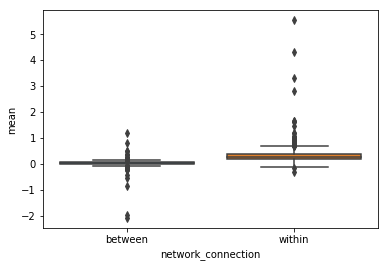

In [21]:
ax = sns.boxplot(x="network_connection", y="mean", data=taskswitch_df)

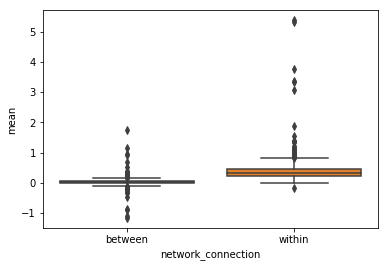

In [22]:
ax = sns.boxplot(x="network_connection", y="mean", data=fauxbold_df)

In [23]:
# combine taskswitch and fauxbold
taskswitch_df['data'] = ['taskswitch'] * taskswitch_df.shape[0]
fauxbold_df['data'] = ['fauxbold'] * fauxbold_df.shape[0]
data_df = pd.concat([taskswitch_df, fauxbold_df])

In [24]:
data_df.head()

,network_connection,source_network,mean,participant,data
0,between,ContA,0.161422,GE120001,taskswitch
1,between,ContB,0.114298,GE120001,taskswitch
2,between,ContC,0.062764,GE120001,taskswitch
3,between,DefaultA,0.037953,GE120001,taskswitch
4,between,DefaultB,0.121116,GE120001,taskswitch


Text(0,0.5,"Mean Correlation (Fisher's Z)")

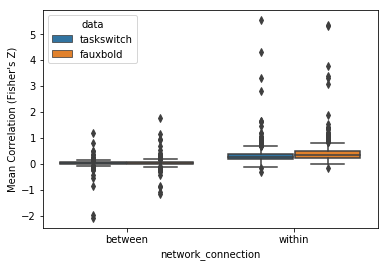

In [25]:
ax = sns.boxplot(x="network_connection", y="mean", hue='data', data=data_df)
ax.set_ylabel("Mean Correlation (Fisher's Z)")

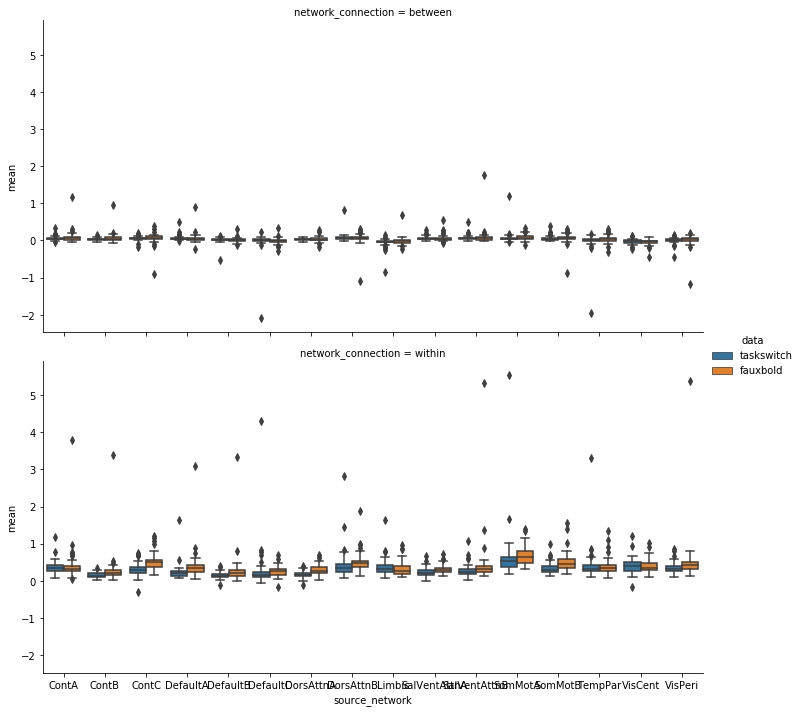

In [26]:

sns.catplot(kind='box', height=5, aspect=2, x='source_network', y='mean', row='network_connection', hue='data', data=data_df)

## Play with Conditional subtraction

In [27]:
fauxbold_repeat_objs = test_layout.get(
    suffix="correlation", extension="tsv", task="fauxbold", desc="repeat")
taskswitch_repeat_objs = test_layout.get(
    suffix="correlation", extension="tsv", task="taskswitch", desc="repeat")

In [28]:
taskswitch_repeat_file = taskswitch_repeat_objs[2].path
taskswitch_switch_file = taskswitch_objs[2].path

In [29]:
fauxbold_repeat_file = fauxbold_repeat_objs[2].path
fauxbold_switch_file = fauxbold_objs[2].path

In [30]:
def _subtract_matrices(file1, file2):
    df1 = pd.read_csv(file1, index_col=0, sep='\t')
    df2 = pd.read_csv(file2, index_col=0, sep='\t')
    diff_df = df1 - df2
    tmp_G = nx.convert_matrix.from_pandas_adjacency(diff_df)
    diff_edge_df = nx.convert_matrix.to_pandas_edgelist(tmp_G)
    diff_edge_df.dropna(inplace=True)
    return diff_edge_df

def _proc_diff_df(edge_df, participant):
    edge_df['source_network'] = edge_df['source'].str.split('-').apply(lambda x: x[1])
    edge_df['target_network'] = edge_df['target'].str.split('-').apply(lambda x: x[1])
    edge_df['network_connection'] = edge_df[['source_network', 'target_network']].apply(_compare_net, axis=1)
    
    info_df = edge_df.groupby(['network_connection', 'source_network']).describe().T.loc[('weight', 'mean'), :].to_frame()
    info_df = edge_df.groupby(['network_connection', 'source_network']).describe().T.loc[('weight', 'mean'), :].to_frame()
    info_df.columns = info_df.columns.droplevel()
    info_df['participant'] = [participant] * info_df.shape[0]
    info_df.reset_index(inplace=True)
    print(f"finished {participant}")
    
    return info_df

def calc_diff_matrices(file1, file2, participant):
    edge_df = _subtract_matrices(file1, file2)
    
    out_df = _proc_diff_df(edge_df, participant)
    
    return out_df

In [31]:

taskswitch_diff_df = _subtract_matrices(taskswitch_switch_file, taskswitch_repeat_file)
fauxbold_diff_df = _subtract_matrices(fauxbold_switch_file, fauxbold_repeat_file)

In [32]:
for edge_df in [taskswitch_diff_df, fauxbold_diff_df]:
    edge_df['source_network'] = edge_df['source'].str.split('-').apply(lambda x: x[1])
    edge_df['target_network'] = edge_df['target'].str.split('-').apply(lambda x: x[1])
    edge_df['network_connection'] = edge_df[['source_network', 'target_network']].apply(_compare_net, axis=1)


In [33]:
taskswitch_diff_df.groupby(['network_connection', 'source_network']).describe().T.loc[('weight', 'mean'), :].to_frame()

weight
                                       mean
network_connection source_network          
between            ContA          -0.017282
                   ContB          -0.010487
                   ContC          -0.030130
                   DefaultA       -0.055385
                   DefaultB       -0.013134
                   DefaultC       -0.000426
                   DorsAttnA       0.031145
                   DorsAttnB       0.014954
                   Limbic          0.017349
                   SalVentAttnA   -0.026499
                   SalVentAttnB   -0.011095
                   SomMotA         0.014099
                   SomMotB        -0.045706
                   TempPar         0.003627
                   VisCent         0.044684
                   VisPeri         0.017881
within             ContA           0.043763
                   ContB           0.008358
                   ContC           0.031301
                   DefaultA       -0.088755
                   DefaultB        0.006330
                   DefaultC       -0.036776
                   DorsAttnA      -0.043066
                   DorsAttnB      -0.076012
                   Limbic          0.042622
                   SalVentAttnA   -0.072132
                   SalVentAttnB   -0.195883
                   SomMotA         0.007735
                   SomMotB         0.019237
                   TempPar         0.018190
                   VisCent        -0.138638
                   VisPeri        -0.047195

In [34]:
fauxbold_diff_df.groupby(['network_connection', 'source_network']).describe().T.loc[('weight', 'mean'), :].to_frame()

weight
                                       mean
network_connection source_network          
between            ContA           0.053947
                   ContB           0.025118
                   ContC           0.038191
                   DefaultA        0.118338
                   DefaultB       -0.042524
                   DefaultC       -0.087935
                   DorsAttnA      -0.015725
                   DorsAttnB       0.009825
                   Limbic         -0.063750
                   SalVentAttnA   -0.024372
                   SalVentAttnB    0.074995
                   SomMotA        -0.090154
                   SomMotB        -0.026043
                   TempPar        -0.057235
                   VisCent         0.010563
                   VisPeri        -0.003162
within             ContA           0.119018
                   ContB           0.028486
                   ContC           0.153681
                   DefaultA        0.285241
                   DefaultB        0.060893
                   DefaultC       -0.181172
                   DorsAttnA      -0.047839
                   DorsAttnB       0.068843
                   Limbic          0.007326
                   SalVentAttnA   -0.049056
                   SalVentAttnB    0.204133
                   SomMotA        -0.256303
                   SomMotB        -0.015034
                   TempPar        -0.344614
                   VisCent        -0.101209
                   VisPeri        -0.112825

In [35]:
with Pool(N_THREADS) as p:
    ts_diff_matrices = p.starmap(calc_diff_matrices, [(f1.path, f2.path, f1.entities['subject']) for f1, f2 in zip(taskswitch_objs, taskswitch_repeat_objs)])

taskswitch_diff_switch_repeat = pd.concat(ts_diff_matrices)

finished GE120036
finished GE120028
finished GE120013
finished GE120019
finished GE120033
finished GE120010
finished GE120023
finished GE120012
finished GE120005
finished GE120003
finished GE120035
finished GE120014
finished GE120011
finished GE120024
finished GE120032
finished GE120006
finished GE120002
finished GE120025
finished GE120018
finished GE120030
finished GE120015
finished GE120017
finished GE120027
finished GE120026
finished GE120034
finished GE120031
finished GE120029
finished GE120004
finished GE120020
finished GE120008
finished GE120021
finished GE120001
finished GE120041
finished GE120040
finished GE120049
finished GE120055
finished GE120039
finished GE120037
finished GE120043
finished GE120038
finished GE120053
finished GE120069
finished GE120059
finished GE120063
finished GE120052
finished GE120057
finished GE120047
finished GE120065
finished GE120058
finished GE120062
finished GE120061
finished GE120050
finished GE120060
finished GE120075
finished GE120045
finished G

In [36]:
with Pool(N_THREADS) as p:
    fb_diff_matrices = p.starmap(calc_diff_matrices, [(f1.path, f2.path, f1.entities['subject']) for f1, f2 in zip(fauxbold_objs, fauxbold_repeat_objs)])

fauxbold_diff_switch_repeat = pd.concat(fb_diff_matrices)

finished GE120014
finished GE120036
finished GE120010
finished GE120029
finished GE120006
finished GE120013
finished GE120003
finished GE120024
finished GE120020
finished GE120023
finished GE120030
finished GE120035
finished GE120028
finished GE120015
finished GE120027
finished GE120012
finished GE120033
finished GE120031
finished GE120026
finished GE120032
finished GE120025
finished GE120011
finished GE120034
finished GE120021
finished GE120018
finished GE120004
finished GE120019
finished GE120008
finished GE120001
finished GE120017
finished GE120005
finished GE120002
finished GE120037
finished GE120038
finished GE120040
finished GE120039
finished GE120041
finished GE120044
finished GE120045
finished GE120042
finished GE120050
finished GE120049
finished GE120043
finished GE120047
finished GE120052
finished GE120054
finished GE120055
finished GE120059
finished GE120057
finished GE120060
finished GE120058
finished GE120062
finished GE120063
finished GE120053
finished GE120061
finished G

In [37]:
taskswitch_diff_switch_repeat['data'] = ['taskswitch'] * taskswitch_diff_switch_repeat.shape[0]
fauxbold_diff_switch_repeat['data'] = ['fauxbold'] * fauxbold_diff_switch_repeat.shape[0]

In [38]:
diff_switch_repeat = pd.concat([taskswitch_diff_switch_repeat, fauxbold_diff_switch_repeat])

In [39]:
diff_switch_repeat

,network_connection,source_network,mean,participant,data
0,between,ContA,0.047714,GE120001,taskswitch
1,between,ContB,0.052964,GE120001,taskswitch
2,between,ContC,-0.029770,GE120001,taskswitch
3,between,DefaultA,-0.017391,GE120001,taskswitch
4,between,DefaultB,0.118658,GE120001,taskswitch
5,between,DefaultC,-0.027678,GE120001,taskswitch
6,between,DorsAttnA,-0.076771,GE120001,taskswitch
7,between,DorsAttnB,0.041171,GE120001,taskswitch
8,between,Limbic,-0.018956,GE120001,taskswitch
9,between,SalVentAttnA,0.117922,GE120001,taskswitch


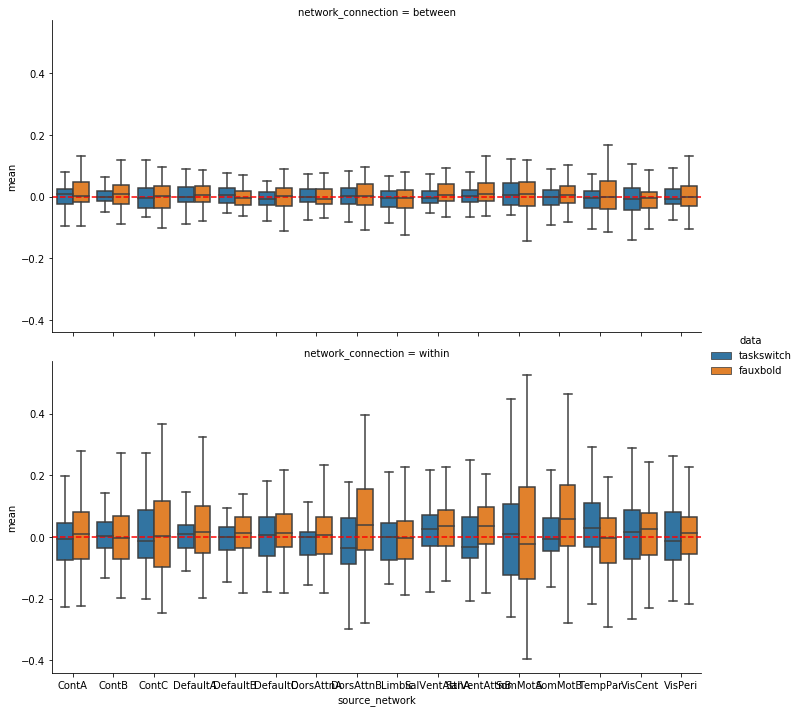

In [40]:
fg = sns.catplot(kind='box', height=5, aspect=2, x='source_network', y='mean', row='network_connection', showfliers=False, hue='data', data=diff_switch_repeat)
for ax in fg.axes.flatten():
    ax.axhline(color='red', linestyle='--')

In [41]:
with Pool(N_THREADS) as p:
    tsf_diff_matrices = p.starmap(calc_diff_matrices, [(f1.path, f2.path, f1.entities['subject']) for f1, f2 in zip(taskswitch_filt_objs, fauxbold_objs)])


task_faux_diff_switch_repeat = pd.concat(tsf_diff_matrices)
task_faux_diff_switch_repeat.head()

finished GE120027
finished GE120036
finished GE120032
finished GE120024
finished GE120001
finished GE120002
finished GE120033
finished GE120026
finished GE120014
finished GE120028
finished GE120031
finished GE120020
finished GE120034
finished GE120006
finished GE120029
finished GE120018
finished GE120019
finished GE120012
finished GE120023
finished GE120008
finished GE120011
finished GE120003
finished GE120021
finished GE120030
finished GE120017
finished GE120015
finished GE120013
finished GE120005
finished GE120010
finished GE120004
finished GE120025
finished GE120035
finished GE120037
finished GE120038
finished GE120040
finished GE120039
finished GE120041
finished GE120044
finished GE120049
finished GE120054
finished GE120047
finished GE120052
finished GE120043
finished GE120050
finished GE120045
finished GE120042
finished GE120057
finished GE120053
finished GE120059
finished GE120055
finished GE120058
finished GE120061
finished GE120065
finished GE120063
finished GE120060
finished G

,network_connection,source_network,mean,participant
0,between,ContA,0.117407,GE120001
1,between,ContB,0.084203,GE120001
2,between,ContC,0.012980,GE120001
3,between,DefaultA,0.026345,GE120001
4,between,DefaultB,0.128848,GE120001


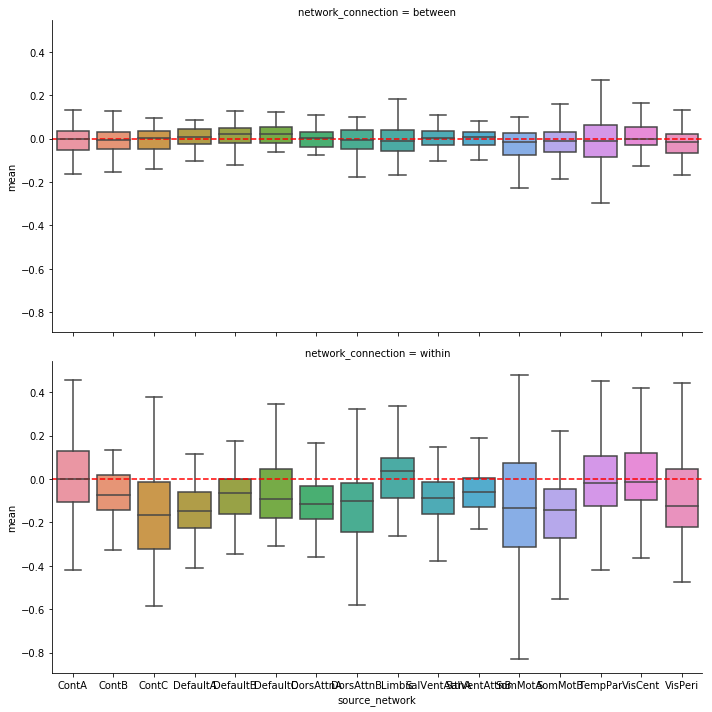

In [42]:
fg = sns.catplot(kind='box', height=5, aspect=2, x='source_network', y='mean', row='network_connection', showfliers=False, data=task_faux_diff_switch_repeat)
for ax in fg.axes.flatten():
    ax.axhline(color='red', linestyle='--')

In [43]:
# make sure there are the same participants in each group
{ob.entities['subject'] for ob in taskswitch_filt_objs} - {ob.entities['subject'] for ob in fauxbold_objs}

set()

In [44]:
def long_df_from_matrix(file, participant):
    adj_df = pd.read_csv(file, index_col=0, sep="\t")
    tmp_G = nx.convert_matrix.from_pandas_adjacency(adj_df)

    edge_df = nx.convert_matrix.to_pandas_edgelist(tmp_G)
    edge_df = edge_df.dropna()
    edge_df['source_target'] = edge_df[['source', 'target']].agg('__'.join, axis=1)
    edge_df['source_network'] = edge_df['source'].str.split('-').apply(lambda x: x[1])
    edge_df['target_network'] = edge_df['target'].str.split('-').apply(lambda x: x[1])
    # edge_df['source_target'] = 
    edge_df['network_connection'] = edge_df[['source_network', 'target_network']].apply(_compare_net, axis=1)
    
    edge_df['participant'] = [participant] * edge_df.shape[0]
    print(f"finished {participant}")
    return edge_df

In [45]:
with Pool(N_THREADS) as p:
    edge_ts_dfs = p.starmap(long_df_from_matrix, [(t.path, t.entities['subject']) for t in taskswitch_filt_objs])


edge_taskswitch_switch = pd.concat(edge_ts_dfs)
edge_taskswitch_switch.head()


finished GE120033
finished GE120004
finished GE120011
finished GE120003
finished GE120036
finished GE120030
finished GE120014
finished GE120017
finished GE120013
finished GE120035
finished GE120012
finished GE120025
finished GE120008
finished GE120032
finished GE120024
finished GE120029
finished GE120034
finished GE120023
finished GE120028
finished GE120031
finished GE120010
finished GE120026
finished GE120018
finished GE120021
finished GE120001
finished GE120015
finished GE120027
finished GE120019
finished GE120020
finished GE120005
finished GE120006
finished GE120002
finished GE120037
finished GE120038
finished GE120040
finished GE120039
finished GE120049
finished GE120045
finished GE120044
finished GE120043
finished GE120057
finished GE120054
finished GE120047
finished GE120055
finished GE120041
finished GE120058
finished GE120059
finished GE120060
finished GE120050
finished GE120053
finished GE120052
finished GE120062
finished GE120061
finished GE120063
finished GE120065
finished G

,source,target,weight,source_target,source_network,target_network,network_connection,participant
1,LH-VisCent-ExStr_1,LH-VisCent-ExStr_2,0.315991,LH-VisCent-ExStr_1__LH-VisCent-ExStr_2,VisCent,VisCent,within,GE120001
2,LH-VisCent-ExStr_1,LH-VisCent-ExStr_3,1.539657,LH-VisCent-ExStr_1__LH-VisCent-ExStr_3,VisCent,VisCent,within,GE120001
3,LH-VisCent-ExStr_1,LH-VisCent-ExStr_4,1.045852,LH-VisCent-ExStr_1__LH-VisCent-ExStr_4,VisCent,VisCent,within,GE120001
4,LH-VisCent-ExStr_1,LH-VisCent-ExStr_5,0.923111,LH-VisCent-ExStr_1__LH-VisCent-ExStr_5,VisCent,VisCent,within,GE120001
5,LH-VisCent-ExStr_1,LH-VisCent-ExStr_6,1.055467,LH-VisCent-ExStr_1__LH-VisCent-ExStr_6,VisCent,VisCent,within,GE120001


In [46]:
with Pool(N_THREADS) as p:
    edge_fb_dfs = p.starmap(long_df_from_matrix, [(t.path, t.entities['subject']) for t in fauxbold_objs])


edge_fauxbold_switch = pd.concat(edge_fb_dfs)
edge_fauxbold_switch.head()

finished GE120008
finished GE120036
finished GE120031
finished GE120024
finished GE120032
finished GE120021
finished GE120026
finished GE120025
finished GE120023
finished GE120013
finished GE120018
finished GE120002
finished GE120001
finished GE120033
finished GE120035
finished GE120030
finished GE120010
finished GE120029
finished GE120034
finished GE120005
finished GE120020
finished GE120011
finished GE120027
finished GE120015
finished GE120028
finished GE120019
finished GE120014
finished GE120004
finished GE120017
finished GE120012
finished GE120006
finished GE120003
finished GE120037
finished GE120038
finished GE120039
finished GE120040
finished GE120042
finished GE120043
finished GE120049
finished GE120041
finished GE120052
finished GE120044
finished GE120045
finished GE120050
finished GE120054
finished GE120047
finished GE120058
finished GE120055
finished GE120057
finished GE120059
finished GE120061
finished GE120053
finished GE120062
finished GE120060
finished GE120065
finished G

,source,target,weight,source_target,source_network,target_network,network_connection,participant
1,LH-VisCent-ExStr_1,LH-VisCent-ExStr_2,0.773114,LH-VisCent-ExStr_1__LH-VisCent-ExStr_2,VisCent,VisCent,within,GE120001
2,LH-VisCent-ExStr_1,LH-VisCent-ExStr_3,0.964944,LH-VisCent-ExStr_1__LH-VisCent-ExStr_3,VisCent,VisCent,within,GE120001
3,LH-VisCent-ExStr_1,LH-VisCent-ExStr_4,0.738996,LH-VisCent-ExStr_1__LH-VisCent-ExStr_4,VisCent,VisCent,within,GE120001
4,LH-VisCent-ExStr_1,LH-VisCent-ExStr_5,0.510130,LH-VisCent-ExStr_1__LH-VisCent-ExStr_5,VisCent,VisCent,within,GE120001
5,LH-VisCent-ExStr_1,LH-VisCent-ExStr_6,1.000533,LH-VisCent-ExStr_1__LH-VisCent-ExStr_6,VisCent,VisCent,within,GE120001


In [47]:
edge_fauxbold_switch['task'] = ['fauxbold'] * edge_fauxbold_switch.shape[0]
edge_taskswitch_switch['task'] = ['taskswitch'] * edge_taskswitch_switch.shape[0]

In [48]:
edge_switch = pd.concat([edge_fauxbold_switch, edge_taskswitch_switch])
edge_switch.head()

,source,target,weight,source_target,source_network,target_network,network_connection,participant,task
1,LH-VisCent-ExStr_1,LH-VisCent-ExStr_2,0.773114,LH-VisCent-ExStr_1__LH-VisCent-ExStr_2,VisCent,VisCent,within,GE120001,fauxbold
2,LH-VisCent-ExStr_1,LH-VisCent-ExStr_3,0.964944,LH-VisCent-ExStr_1__LH-VisCent-ExStr_3,VisCent,VisCent,within,GE120001,fauxbold
3,LH-VisCent-ExStr_1,LH-VisCent-ExStr_4,0.738996,LH-VisCent-ExStr_1__LH-VisCent-ExStr_4,VisCent,VisCent,within,GE120001,fauxbold
4,LH-VisCent-ExStr_1,LH-VisCent-ExStr_5,0.510130,LH-VisCent-ExStr_1__LH-VisCent-ExStr_5,VisCent,VisCent,within,GE120001,fauxbold
5,LH-VisCent-ExStr_1,LH-VisCent-ExStr_6,1.000533,LH-VisCent-ExStr_1__LH-VisCent-ExStr_6,VisCent,VisCent,within,GE120001,fauxbold


In [49]:
# 0.99 r == 2.647 z (this is the max z score I would be interested in, anything above does not explain meaningful differences)
THRESH = 2.647
edge_switch['weight'] = edge_switch['weight'].clip(-THRESH, THRESH)

In [50]:
sample_roi_test = edge_switch[edge_switch['source_target'] == 'LH-VisCent-ExStr_1__LH-VisCent-ExStr_2']

In [51]:
import os
R_PATH = "/home/jdkent/envs/aim1_valid/lib/R"
os.environ['R_HOME'] = R_PATH

In [52]:
from rpy2 import robjects as robj
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr


In [53]:
from functools import partial
def select_subset(ddf, val):
    return (ddf[ddf['source_target'] == val], val)

#with Pool(N_THREADS) as p:
#    sel_sub = partial(select_subset, edge_switch)
#    subset_tuples = p.starmap(sel_sub, list(set(df['source_target'].tolist())))

In [54]:
def _bind_matrices(objs, label):
    dfs = [pd.read_csv(obj.path, index_col=0, sep='\t') for obj in objs]
    participant_ids = [obj.entities['subject'] for obj in objs]
    names = dfs[0].columns
    upper_idxs = np.triu_indices(len(names), k=1)
    new_colnames = ['__'.join([names[i], names[j]]) for i, j in zip(*upper_idxs)]
    wide_df = pd.DataFrame(np.array([df.values[upper_idxs] for df in dfs]), columns=new_colnames)
    wide_df['participant_id'] = participant_ids
    wide_df['task'] = [label] * len(participant_ids)
    return wide_df

In [55]:
switch_wide_df = pd.concat([_bind_matrices(taskswitch_objs, 'taskswitch'), _bind_matrices(fauxbold_objs, 'fauxbold')])
switch_wide_df.head()

,LH-VisCent-ExStr_1__LH-VisCent-ExStr_2,LH-VisCent-ExStr_1__LH-VisCent-ExStr_3,LH-VisCent-ExStr_1__LH-VisCent-ExStr_4,LH-VisCent-ExStr_1__LH-VisCent-ExStr_5,LH-VisCent-ExStr_1__LH-VisCent-ExStr_6,LH-VisCent-ExStr_1__LH-VisCent-ExStr_7,LH-VisCent-ExStr_1__LH-VisCent-ExStr_8,LH-VisCent-ExStr_1__LH-VisCent-ExStr_9,LH-VisCent-ExStr_1__LH-VisCent-ExStr_10,LH-VisCent-ExStr_1__LH-VisCent-ExStr_11,...,RH-TempPar-6__RH-TempPar-9,RH-TempPar-6__RH-TempPar-10,RH-TempPar-7__RH-TempPar-8,RH-TempPar-7__RH-TempPar-9,RH-TempPar-7__RH-TempPar-10,RH-TempPar-8__RH-TempPar-9,RH-TempPar-8__RH-TempPar-10,RH-TempPar-9__RH-TempPar-10,participant_id,task
0,0.315991,1.539657,1.045852,0.923111,1.055467,0.693563,0.452037,0.980423,0.523014,-0.021258,...,0.557836,0.194680,0.804195,0.803618,0.351371,0.665534,0.568753,1.073921,GE120001,taskswitch
1,0.826873,0.847774,0.645128,0.086749,0.434368,0.221788,-0.026288,0.218747,0.069924,-0.238165,...,0.757530,0.334073,1.498732,1.149092,0.638715,1.075586,0.702692,0.809416,GE120002,taskswitch
2,0.934346,0.930718,0.964107,0.833314,0.617604,0.595888,-0.193424,-0.330613,-0.309816,-0.320682,...,0.516416,0.307560,0.888054,1.034993,0.616065,0.901156,0.368418,0.923161,GE120003,taskswitch
3,0.413696,0.540163,0.739708,0.499359,0.707607,0.561109,0.068396,0.621308,0.519370,0.554776,...,-0.116669,0.172950,0.999064,-0.005146,-0.140464,0.316279,0.269674,0.515529,GE120004,taskswitch
4,0.881957,0.556033,0.770083,0.744237,0.915860,0.460484,0.536075,0.738461,0.457995,0.214080,...,0.396034,0.114421,1.030528,1.072174,0.512103,1.919318,0.999848,1.019615,GE120005,taskswitch


In [56]:
from functools import partial
stats = importr('stats')
base = importr('base')

def _run_model(df, col):
    filt_df = df[['participant_id', 'task', col]]
    filt_df = filt_df.rename({col: 'correlation'}, axis=1)
    collector_dict = {'source_target': None, 'p_value': None, 'estimate': None}
    with localconverter(robj.default_converter + pandas2ri.converter):
          r_df = robj.conversion.py2rpy(filt_df)
    model = stats.lm(formula='correlation ~ task', data=r_df)
    summary = base.summary(model)
    res = summary.rx2('coefficients')
    p_val = res[7]
    estimate = res[1]
    # print(col)
    # print(res)
    collector_dict['source_target'] = col
    collector_dict['p_value'] = p_val
    collector_dict['estimate'] = estimate
    return collector_dict

def model_corr_diff_mt(wide_df):
    #run_model = partial(_run_model, wide_df)
    cols = set(wide_df.columns)
    cols = list(cols - set(["task", "participant_id"]))
    args = [(wide_df[['participant_id', 'task', col]], col) for col in cols]
    with Pool(N_THREADS) as p:
        sep_dicts = p.starmap(_run_model, args)
    dict_collector = {
            k: [d.get(k) for d in sep_dicts]
            for k in set().union(*sep_dicts)}
    model_df = pd.DataFrame.from_dict(dict_collector)
    return model_df

In [57]:
model_df = model_corr_diff_mt(switch_wide_df)

In [58]:
p_value_df = model_df[['p_value', 'source_target']]

In [59]:
p_value_df.head()

,p_value,source_target
0,0.216313,LH-TempPar-4__RH-TempPar-1
1,0.061072,LH-SomMotB-Aud_3__LH-SomMotB-Aud_14
2,0.010430,RH-SomMotA-19__RH-DefaultA-PCC_4
3,0.412155,RH-SomMotB-S2_8__RH-ContB-Temp_2
4,0.269043,LH-VisCent-ExStr_6__RH-DefaultA-PFCm_5


In [60]:
p_value_df[["source", "target"]] = p_value_df["source_target"].str.split('__', expand=True)

In [61]:
p_value_adj = nx.to_pandas_adjacency(nx.from_pandas_edgelist(p_value_df, edge_attr='p_value'), weight='p_value')

In [62]:

def _flip_hemi_net(w):
    comps = w.split('-')
    return '-'.join([comps[1], comps[0]]) + '_' + ''.join(comps[2:])


p_value_renamed = p_value_adj.rename(_flip_hemi_net, axis=1).rename(_flip_hemi_net, axis=0)

In [63]:
col_list = p_value_renamed.columns.tolist()
col_list.sort()

In [64]:
p_value_renamed = p_value_renamed.loc[col_list, col_list]

In [65]:
p_value_inv = 1 - p_value_renamed

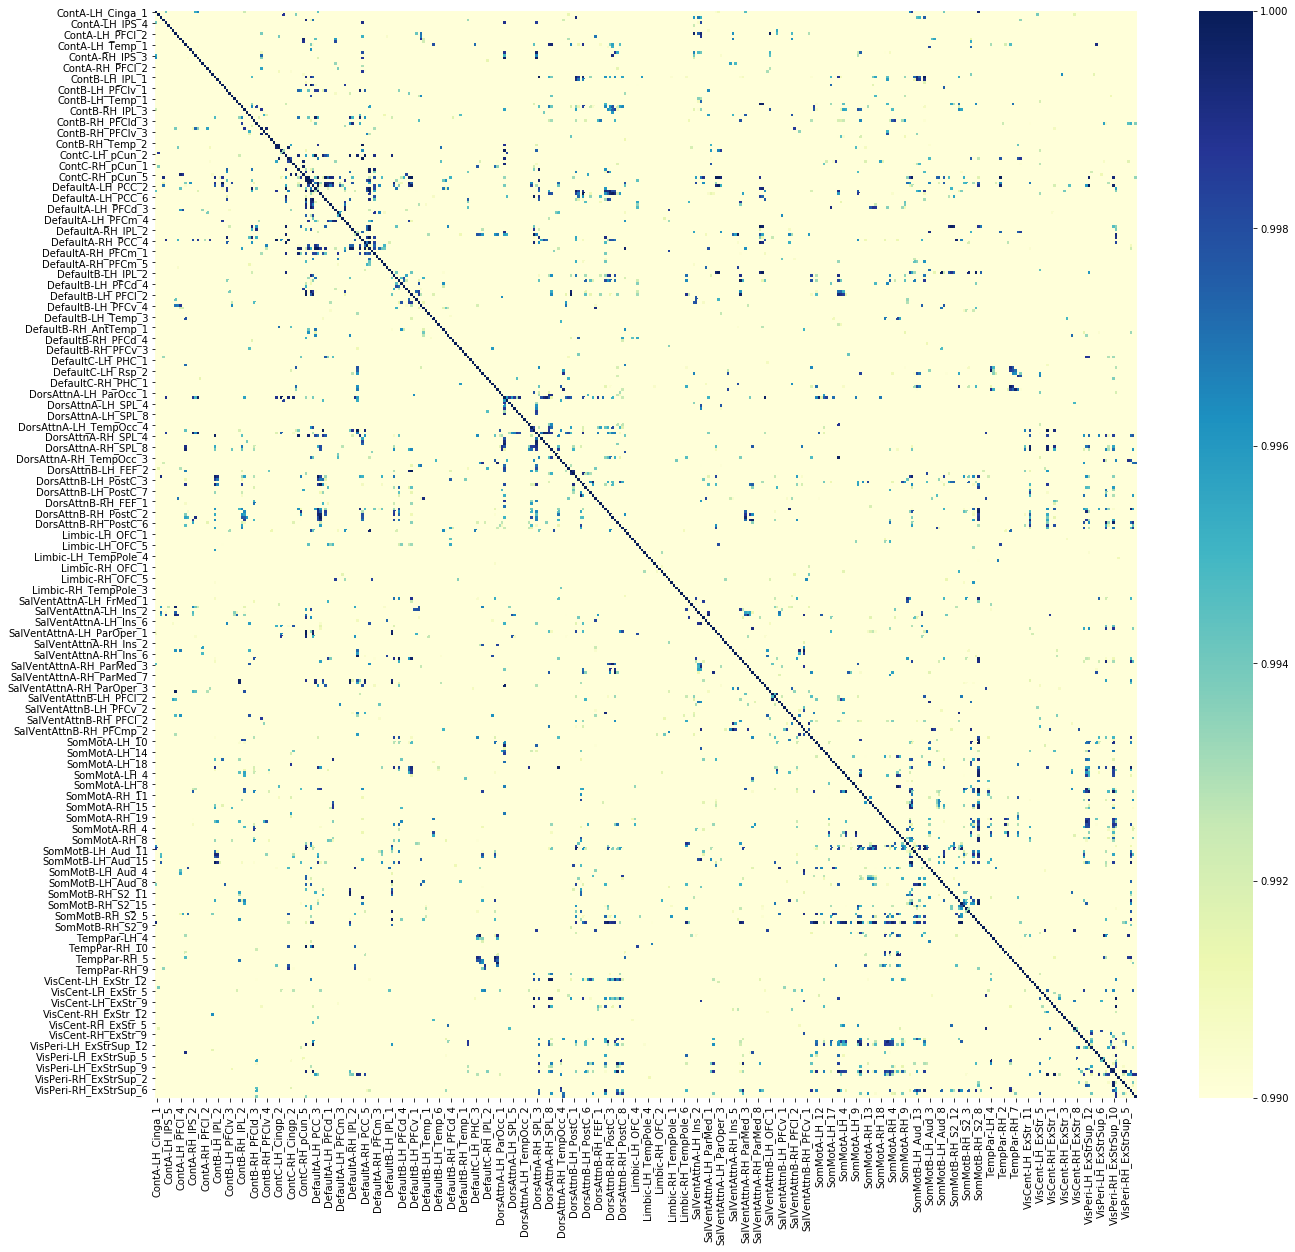

In [66]:
fig, ax = plt.subplots(figsize=(22, 20))
sns.heatmap(p_value_inv, vmin=0.99, vmax=1.0, cmap="YlGnBu", ax=ax)

In [67]:
idxs = np.triu_indices(p_value_renamed.shape[0], k=1)

In [68]:
# false discovery rate (Benjamini/Hochberg)
p_values_sig, p_value_fdr, _, _ = multipletests(p_value_renamed.values[idxs], alpha=0.05, method='fdr_bh')

In [69]:
# only one significant p-value...
p_value_fdr[p_values_sig]

array([0.04522034])

In [70]:
def _edge_to_adj(df, measure):
    df[["source", "target"]] = df["source_target"].str.split('__', expand=True)
    return nx.to_pandas_adjacency(nx.from_pandas_edgelist(df, edge_attr=measure), weight=measure)

def _sort_columns(df):
    def _flip_hemi_net(w):
        comps = w.split('-')
        return '-'.join([comps[1], comps[0]]) + '_' + ''.join(comps[2:])
    
    df_rename = df.rename(_flip_hemi_net, axis=1).rename(_flip_hemi_net, axis=0)
    col_list = df_rename.columns.tolist()
    col_list.sort()

    return df_rename.loc[col_list, col_list]

def make_symmetric_df(df, measure):
    tmp_df = _edge_to_adj(df, measure)
    pretty_df = _sort_columns(tmp_df)
    
    return pretty_df

In [71]:
estimate_df = make_symmetric_df(model_df, "estimate")

In [72]:
# estimate_df.columns = estimate_df.columns.str.split('-', n=1, expand=True)
# estimate_df.index = estimate_df.index.str.split('-', n=1, expand=True)
estimate_df.head()

,ContA-LH_Cinga_1,ContA-LH_IPS_1,ContA-LH_IPS_2,ContA-LH_IPS_3,ContA-LH_IPS_4,ContA-LH_IPS_5,ContA-LH_PFCd_1,ContA-LH_PFCl_1,ContA-LH_PFCl_2,ContA-LH_PFCl_3,...,VisPeri-RH_ExStrSup_10,VisPeri-RH_ExStrSup_11,VisPeri-RH_ExStrSup_2,VisPeri-RH_ExStrSup_3,VisPeri-RH_ExStrSup_4,VisPeri-RH_ExStrSup_5,VisPeri-RH_ExStrSup_6,VisPeri-RH_ExStrSup_7,VisPeri-RH_ExStrSup_8,VisPeri-RH_ExStrSup_9
ContA-LH_Cinga_1,0.000000,0.056208,0.260768,0.290414,0.414680,0.311119,-0.108657,-0.163018,0.184484,0.321186,...,-0.246774,-0.124766,0.027785,0.152391,-0.035719,-0.061105,-0.128835,-0.288927,-0.147185,-0.192857
ContA-LH_IPS_1,0.056208,0.000000,-0.031207,0.079592,-0.110191,-0.033885,-0.306391,-0.253969,-0.103837,-0.086018,...,0.099763,0.196058,0.249424,0.161687,0.333284,0.259671,0.068828,0.180643,-0.120693,-0.058497
ContA-LH_IPS_2,0.260768,-0.031207,0.000000,0.113754,0.162458,0.085013,-0.271417,-0.309149,-0.090830,0.017923,...,-0.024065,0.135414,0.241781,0.249332,0.247577,0.206107,-0.021416,0.060660,-0.050128,-0.024259
ContA-LH_IPS_3,0.290414,0.079592,0.113754,0.000000,0.080884,0.100698,-0.140650,-0.218407,-0.018943,-0.042988,...,-0.115927,0.173746,0.263891,0.251697,0.359937,0.325981,0.069609,0.187282,-0.037196,0.010193
ContA-LH_IPS_4,0.414680,-0.110191,0.162458,0.080884,0.000000,-0.092063,-0.304169,-0.267567,-0.000533,-0.091700,...,-0.053244,0.094964,0.296566,0.303437,0.222772,0.172318,0.043541,0.077199,-0.047718,-0.033255


NameError: name 'network_labels_idxs' is not defined

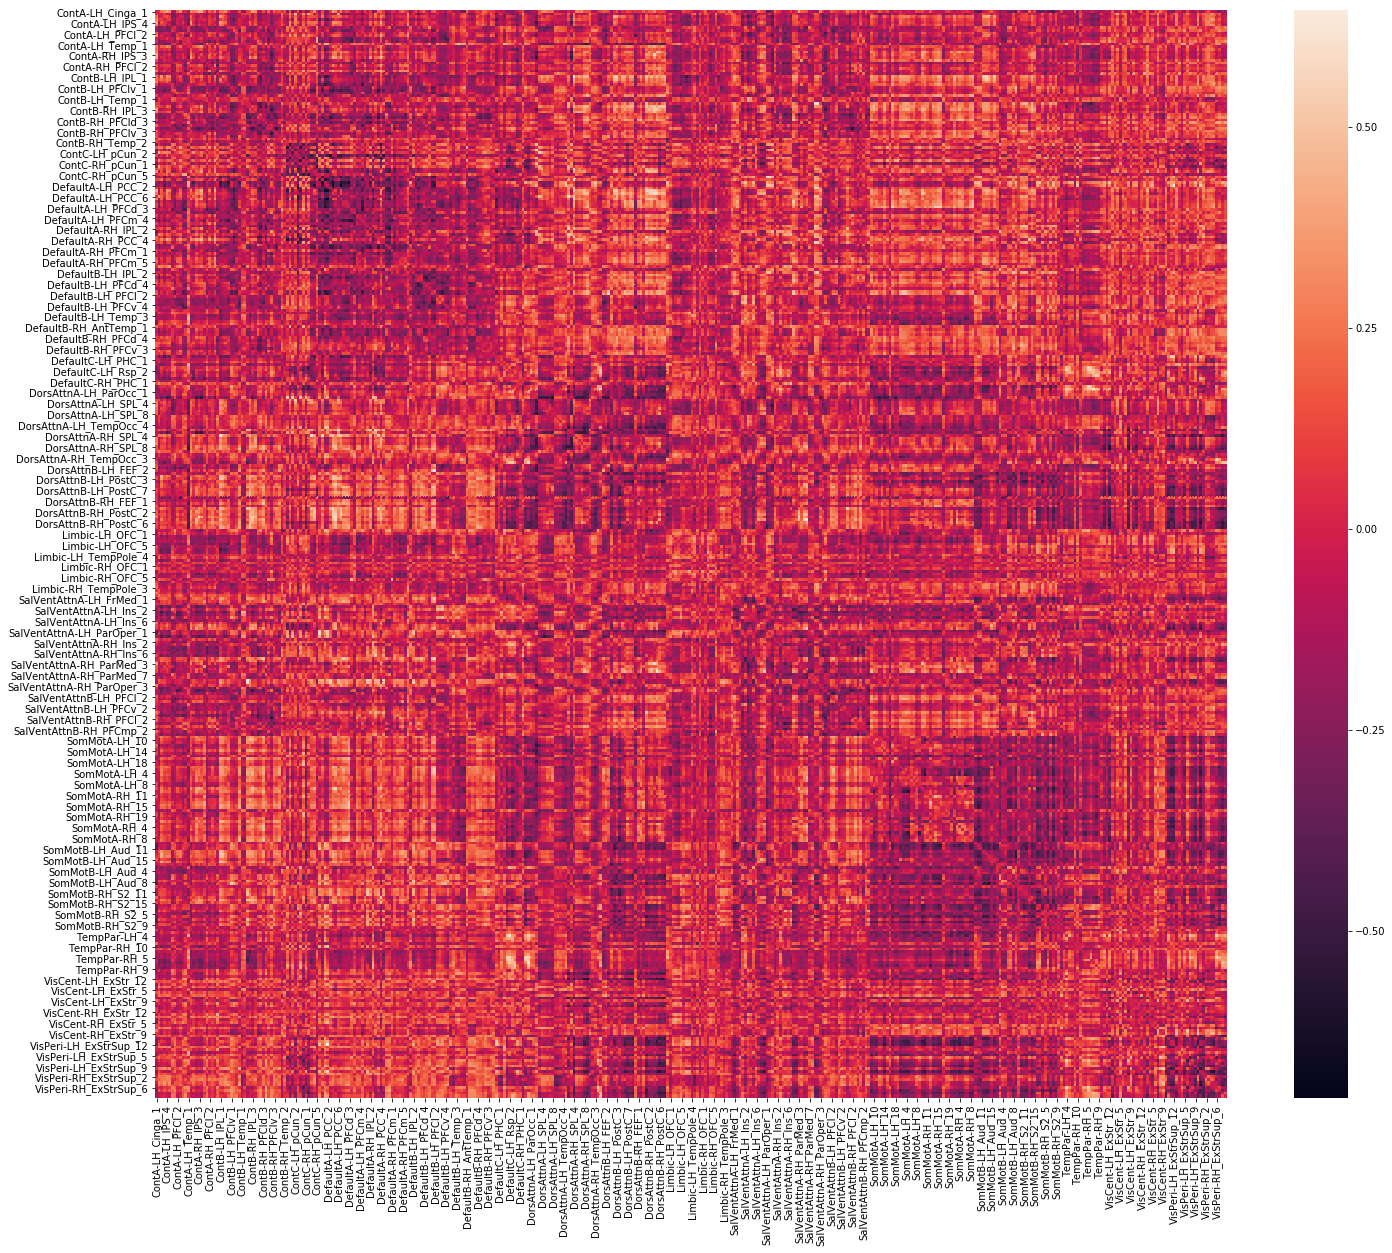

In [73]:
fig, ax = plt.subplots(figsize=(24, 20))
ax = sns.heatmap(estimate_df, ax=ax)
ax.hlines(network_labels_idxs, xmin=0, xmax=estimate_df.shape[0])
ax.vlines(network_labels_idxs, ymin=0, ymax=estimate_df.shape[1])
# twiny = ax.twiny()

ax.tick_params(length=0)
ax.set_ylim(bottom=estimate_df.shape[0], top=0)
ax.set_yticks(midpoints)
ax.set_yticklabels(columns.unique(), fontdict={'fontsize': 'large', 'fontweight': 'heavy'}, va="center")

ax.set_xlim(left=0, right=estimate_df.shape[1])
ax.set_xticks(midpoints)
ax.set_xticklabels(columns.unique(), fontdict={'fontsize': 'large', 'fontweight': 'heavy'}, ha="center")
# twinx.set_label("asdafasdf")

In [74]:
twinx.get_yticks()
yax = twinx.get_yaxis()

NameError: name 'twinx' is not defined

In [75]:
twinx.set_ylim()

NameError: name 'twinx' is not defined

In [76]:
# get the network assignments
columns = estimate_df.columns.str.split('-', n=1, expand=True).get_level_values(0)

In [77]:
network_labels_idxs = np.where(np.roll(columns,1)!=columns)[0]

In [78]:
# network_idxs
# https://stackoverflow.com/questions/19125661/find-index-where-elements-change-value-numpy
network_change_idxs = np.where(columns[:-1] != columns[1:])[0] + 1

In [79]:
twinx = ax.twinx()

In [80]:
columns[:-1]

Index(['ContA', 'ContA', 'ContA', 'ContA', 'ContA', 'ContA', 'ContA', 'ContA',
       'ContA', 'ContA',
       ...
       'VisPeri', 'VisPeri', 'VisPeri', 'VisPeri', 'VisPeri', 'VisPeri',
       'VisPeri', 'VisPeri', 'VisPeri', 'VisPeri'],
      dtype='object', length=399)

In [81]:
columns[1:]

Index(['ContA', 'ContA', 'ContA', 'ContA', 'ContA', 'ContA', 'ContA', 'ContA',
       'ContA', 'ContA',
       ...
       'VisPeri', 'VisPeri', 'VisPeri', 'VisPeri', 'VisPeri', 'VisPeri',
       'VisPeri', 'VisPeri', 'VisPeri', 'VisPeri'],
      dtype='object', length=399)

In [82]:
estimate_df.index

Index(['ContA-LH_Cinga_1', 'ContA-LH_IPS_1', 'ContA-LH_IPS_2',
       'ContA-LH_IPS_3', 'ContA-LH_IPS_4', 'ContA-LH_IPS_5', 'ContA-LH_PFCd_1',
       'ContA-LH_PFCl_1', 'ContA-LH_PFCl_2', 'ContA-LH_PFCl_3',
       ...
       'VisPeri-RH_ExStrSup_10', 'VisPeri-RH_ExStrSup_11',
       'VisPeri-RH_ExStrSup_2', 'VisPeri-RH_ExStrSup_3',
       'VisPeri-RH_ExStrSup_4', 'VisPeri-RH_ExStrSup_5',
       'VisPeri-RH_ExStrSup_6', 'VisPeri-RH_ExStrSup_7',
       'VisPeri-RH_ExStrSup_8', 'VisPeri-RH_ExStrSup_9'],
      dtype='object', length=400)

In [83]:
tmp_idx = np.append(network_labels_idxs, 400)

In [84]:
midpoints = (tmp_idx[1:] + tmp_idx[:-1]) // 2

In [85]:
def _make_pretty_schaefer_heatmap(adj_df):
    if adj_df.shape[0] != adj_df.shape[1]:
        raise ValueError("The dataframe is not square")

    # get the network assignments (assumed name is like ContA-LH_SPL_1)
    networks = adj_df.columns.str.split('-', n=1, expand=True).get_level_values(0)
    # at what indices do the networks change (e.g., go from ContA to ContB)
    network_change_idxs = np.where(np.roll(networks,1)!=networks)[0]
    # find the midpoint index in each network to place a label
    tmp_idx = np.append(network_change_idxs, adj_df.shape[0])
    midpoints = (tmp_idx[1:] + tmp_idx[:-1]) // 2
    
    # create figure axes to plot onto
    fig, ax = plt.subplots(figsize=(24, 20))
    # make the heatmap
    ax = sns.heatmap(adj_df, ax=ax)
    # add horizontal (hlines) and vertical (vlines) to delimit networks
    ax.hlines(network_change_idxs, xmin=0, xmax=adj_df.shape[0])
    ax.vlines(network_change_idxs, ymin=0, ymax=adj_df.shape[1])
    
    # remove ticklines on the axes
    ax.tick_params(length=0)
    
    # add network labels to the y-axis
    ax.set_yticks(midpoints)
    ax.set_yticklabels(networks.unique(), fontdict={'fontsize': 'large', 'fontweight': 'heavy'}, va="center")

    # add network labels to the x-axis
    ax.set_xticks(midpoints)
    ax.set_xticklabels(networks.unique(), fontdict={'fontsize': 'large', 'fontweight': 'heavy'}, ha="center")

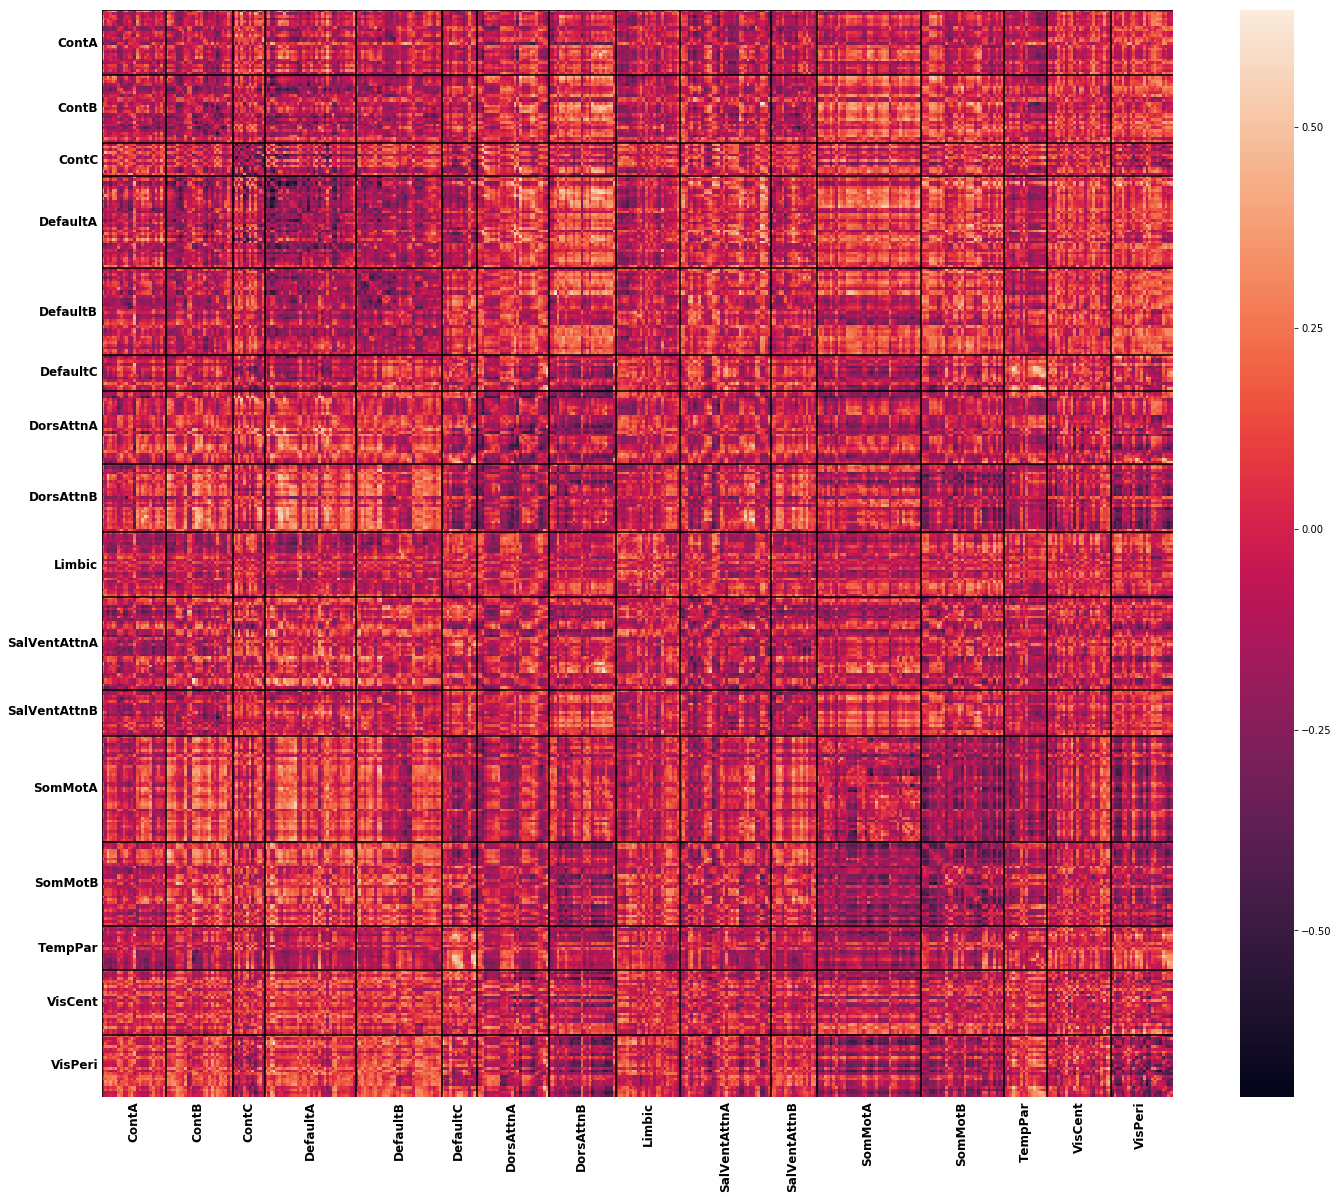

In [86]:
_make_pretty_schaefer_heatmap(estimate_df)

In [101]:
from bct.algorithms.modularity import community_louvain, ls2ci, ci2ls
from bct.algorithms.clustering import clustering_coef_wu_sign
from bct.algorithms.centrality import participation_coef_sign, participation_coef

In [88]:
test_arr = pd.read_csv(fauxbold_objs[0].path, index_col=0, sep='\t').values

In [89]:
test_arr = np.tanh(test_arr)

In [90]:
np.fill_diagonal(test_arr, 0)
test_arr

array([[ 0.        ,  0.64873665,  0.74647397, ...,  0.01105397,
         0.25217112,  0.23876174],
       [ 0.64873665,  0.        ,  0.43984579, ..., -0.06284814,
         0.17493502,  0.06123382],
       [ 0.74647397,  0.43984579,  0.        , ...,  0.20121157,
         0.3431181 ,  0.2787238 ],
       ...,
       [ 0.01105397, -0.06284814,  0.20121157, ...,  0.        ,
         0.49598199,  0.46860285],
       [ 0.25217112,  0.17493502,  0.3431181 , ...,  0.49598199,
         0.        ,  0.80572637],
       [ 0.23876174,  0.06123382,  0.2787238 , ...,  0.46860285,
         0.80572637,  0.        ]])

In [91]:
test_arr[np.isnan(test_arr)]

array([], dtype=float64)

In [92]:
ci, modularity = community_louvain(test_arr, B='negative_asym', ci=columns)

In [93]:
ci

array([1, 3, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 3, 2, 2, 3, 2, 2, 2, 1, 2, 2,
       1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1,
       3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 1, 1, 3,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 2,
       2, 2, 2, 3, 1, 1, 2, 1, 1, 1, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 1, 3,
       2, 2, 1, 2, 2, 3, 2, 1, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 3, 1, 3, 3, 2, 2, 2, 2, 2, 3, 3, 3, 3, 1, 1,
       3, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 3, 3, 2, 2, 1, 2, 1, 2,
       2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3,
       3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 1, 3, 1,
       2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 2, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [94]:
modularity

0.39717665692570364

In [95]:
input_ci = []
idx = 1
prev_col = columns[0]
for column in columns:
    if column == prev_col:
        input_ci.append(idx)
    else:
        idx += 1
        input_ci.append(idx)
    prev_col = column

    

In [96]:
input_ci

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 

In [97]:
columns[318]

'SomMotB'

In [98]:
clustering_coef_wu_sign(test_arr, coef_type='constantini')

array([0.12236286, 0.22904827, 0.10564457, 0.11324889, 0.10388713,
       0.11394799, 0.21286608, 0.1625268 , 0.12839128, 0.15227893,
       0.17816102, 0.11739374, 0.17654049, 0.11833024, 0.19058782,
       0.14344004, 0.24097393, 0.21623998, 0.22362326, 0.21287597,
       0.20376532, 0.25029817, 0.12381086, 0.17786282, 0.2522613 ,
       0.24617461, 0.29167975, 0.30261914, 0.29818091, 0.2661618 ,
       0.26641001, 0.21432585, 0.28583512, 0.28949357, 0.26670869,
       0.23662987, 0.21033719, 0.21535268, 0.19819088, 0.2480691 ,
       0.23221317, 0.22061045, 0.22344389, 0.17465797, 0.18725098,
       0.20204779, 0.29718382, 0.25977332, 0.1300379 , 0.16096347,
       0.29397275, 0.27762785, 0.24051756, 0.26203692, 0.28532255,
       0.26836796, 0.13493205, 0.27130011, 0.20874455, 0.22423092,
       0.21869613, 0.11961192, 0.14757297, 0.1507601 , 0.13466614,
       0.18394041, 0.13376396, 0.21856466, 0.24362449, 0.27129785,
       0.21970305, 0.2682328 , 0.25890016, 0.2611305 , 0.25722

In [113]:
pos, neg = participation_coef_sign(test_arr, columns)

In [108]:
res = (test_arr * (test_arr > 0))

In [114]:
pos_coef = participation_coef(res, columns)

In [116]:
all(pos_coef == pos)

True

In [117]:
columns

Index(['ContA', 'ContA', 'ContA', 'ContA', 'ContA', 'ContA', 'ContA', 'ContA',
       'ContA', 'ContA',
       ...
       'VisPeri', 'VisPeri', 'VisPeri', 'VisPeri', 'VisPeri', 'VisPeri',
       'VisPeri', 'VisPeri', 'VisPeri', 'VisPeri'],
      dtype='object', length=400)